# NYC libraries serving low broadband penetration areas
Across NYC, there are some substantial economic disparities within and between neighborhoods.  One of the ways this can manifest is in the ability to afford computers or broadband internet service at home.  

While open data can in theory be accessed on a phone, it's much more convenient and comfortable on a computer. Libraries in our three library systems are spread throughout the city, and branches near areas with low levels of broadband penetration could find receptive audiences for open data training.

We can combine a variety of open data sources to locate these areas and their nearby library branches.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Computer and broadband statistics
We can find information on the prevalence of computer ownership and broadband subscriptions using the US Census Bureau's American Community Survey.  The most recent reliable figures are from 2019, and to get sub-county geographic granularity, we need to look at the five-year aggregated results. Using the Census API, we can retrieve these ACS variables for each census tract in New York state:

| Variable name | Concept | Label |
|-------------|-----------|-------|
| B28003_001E | Presence of a computer and type of internet subscription in household | Estimate > Total|
| B28003_001M | Presence of a computer and type of internet subscription in household | Margin of Error > Total|
| B28003_004E | Presence of a computer and type of internet subscription in household | Estimate > Total > Has a computer > With a broadband Internet subscription|
| B28003_004M | Presence of a computer and type of internet subscription in household | Margin of Error > Total > Has a computer > With a broadband Internet subscription|

First, we fetch the data from the Census API. Note that`state=36` in the URL refers to New York by its FIPS state code.

In [2]:
df = pd.read_json('https://api.census.gov/data/2019/acs/acs5?get=NAME,B28003_001E,B28003_001M,B28003_004E,B28003_004M&for=tract:*&in=state:36')

In the returned data, the first row contains the variable names. 
We set the data frame's column names to these, then drop the row.

In [3]:
df.columns = df.iloc[0]
df = df.iloc[1:]

Next, let's give the columns to descriptive names for readability.

In [4]:
df = df.rename(columns={
    'county': 'COUNTYFP',
    'state': 'STATEFP',
    'tract': 'TRACTCE',
    'B28003_001E': 'TOTAL',
    'B28003_001M': 'TOTAL_MOE',
    'B28003_004E': 'HAVE_COMPUTER_AND_BROADBAND',
    'B28003_004M': 'HAVE_COMPUTER_AND_BROADBAND_MOE',
})

The retrieved data are all strings. Now we need to convert them to numerical values.

In [5]:
df[['TOTAL', 'TOTAL_MOE', 'HAVE_COMPUTER_AND_BROADBAND', 'HAVE_COMPUTER_AND_BROADBAND_MOE']] = \
    df[['TOTAL', 'TOTAL_MOE', 'HAVE_COMPUTER_AND_BROADBAND', 'HAVE_COMPUTER_AND_BROADBAND_MOE']].astype(int)

The retrieved data are all counts. In order to facilitate comparisons across geographic areas, let's turn them into percentages.  We can do some arithmetic to estimate the margin of error for the percentage, too.

In [6]:
df['PCT_HAVE_COMPUTER_AND_BROADBAND'] = df['HAVE_COMPUTER_AND_BROADBAND'] / df['TOTAL']
df['PCT_HAVE_COMPUTER_AND_BROADBAND_MOE'] = np.sqrt(
    df['HAVE_COMPUTER_AND_BROADBAND_MOE']**2 - 
    df['PCT_HAVE_COMPUTER_AND_BROADBAND']**2 * df['TOTAL_MOE']**2
) / df['TOTAL']

/home/nkrishna/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


These are not percentages yet, just ratios.  Multiply by 100 to switch.

In [7]:
df['PCT_HAVE_COMPUTER_AND_BROADBAND'] *= 100
df['PCT_HAVE_COMPUTER_AND_BROADBAND_MOE'] *= 100

Let's take a quick look to see what the data look like.

In [8]:
df.head().T

,1,2,3,4,5
0,,,,,
NAME,"Census Tract 55, Onondaga County, New York","Census Tract 56.01, Onondaga County, New York","Census Tract 61.02, Onondaga County, New York","Census Tract 112.01, Onondaga County, New York","Census Tract 56.02, Onondaga County, New York"
TOTAL,1820,694,1305,1507,63
TOTAL_MOE,149,55,124,100,24
HAVE_COMPUTER_AND_BROADBAND,1350,630,861,1292,32
HAVE_COMPUTER_AND_BROADBAND_MOE,170,65,121,134,20
STATEFP,36,36,36,36,36
COUNTYFP,067,067,067,067,067
TRACTCE,005500,005601,006102,011201,005602
PCT_HAVE_COMPUTER_AND_BROADBAND,74.175824,90.778098,65.977011,85.733245,50.793651


That's all the cleanup needed for this data. Let's save a local copy.

In [9]:
df.to_csv('/mnt/c/temp/nys-broadband.csv', index=False)

## Tract maps
Since Census tracts are made up by the Census Bureau, that's where we need to look to get maps for them. We need to take care to use the same vintage (2019) as we used for the ACS survey.

In [10]:
tracts = gpd.read_file('/vsizip//vsicurl/https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_36_tract.zip')

## NYC library locations
There's a dataset with all the NYC library systems' branches on the open data portal. It might be a little out of date, but seems like a great place to start.

In [11]:
libraries = gpd.read_file(
    'https://data.cityofnewyork.us/api/geospatial/p4pf-fyc4?method=export&format=GeoJSON',
    driver='GeoJSON')

## Crossing the streams!
Next we want to merge our datasets and restrict ourselves to data within the five boroughs.

We want to use the state and county FIPS codes and the tract IDs to merge the broadband penetration data with our map data.

In [12]:
df = df.set_index(['STATEFP', 'COUNTYFP', 'TRACTCE'])
tracts = tracts.set_index(['STATEFP', 'COUNTYFP', 'TRACTCE'])
joined = tracts.join(df.drop(columns=['NAME'])) # drop "NAME" since it's a duplicated column name

We'll manually restrict our data to New York City using a list of the boroughs' FIPS codes.

In [13]:
nyc_counties = {
    '005': 'Bronx County',
    '047': 'Kings County',
    '061': 'New York County',
    '081': 'Queens County',
    '085': 'Richmond County',
}
nyc_joined = joined.loc[pd.IndexSlice['36', [countyfp for countyfp in nyc_counties], :]]

# Identifying libraries near low broadband penetration areas
"Areas" here refers to census tracts.  For demo purposes, we'll define "low broadband penetration" as being below a threshold of 60%.

In [14]:
low_broadband_tracts = nyc_joined['PCT_HAVE_COMPUTER_AND_BROADBAND'] < 60
sum(low_broadband_tracts)

94

In [15]:
low_broadband_libraries = libraries.intersects(nyc_joined[low_broadband_tracts].unary_union)
sum(low_broadband_libraries)

12

Let's take a look at these on a map.  

Symbology:
* Each borough has a separate color
* Tract boundaries are gray
* Tracts with low broadband penetration are bright yellow
* Libraries are red stars

<AxesSubplot:>

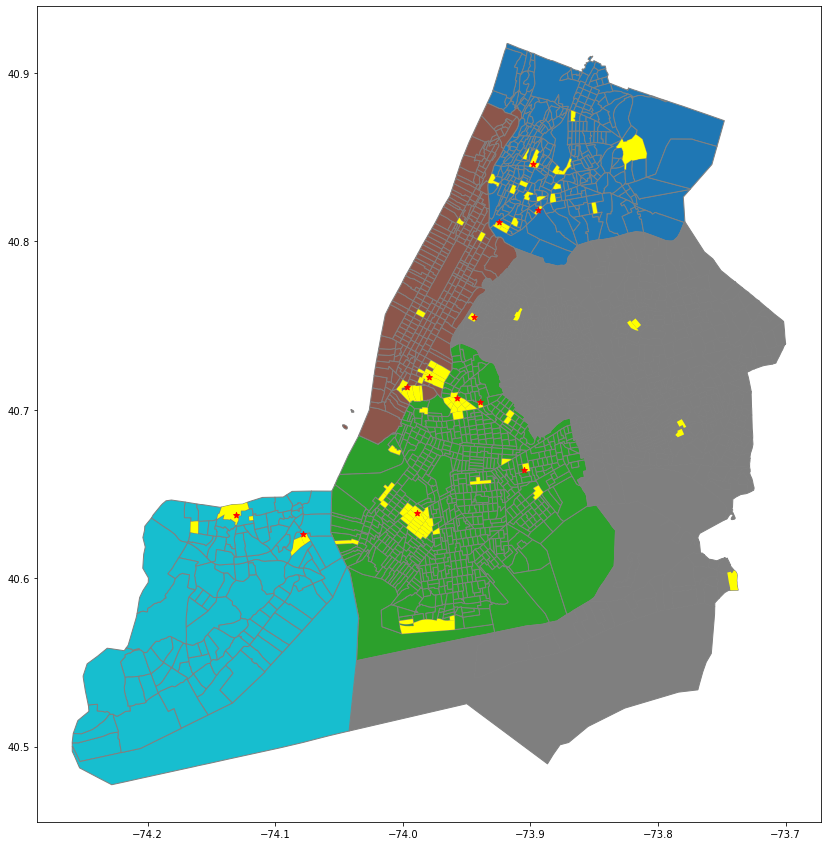

In [16]:
plt.figure(figsize=(15,15))
# The reset_index() here is just to let us use the county FIPS codes to color the counties distinctly.
nyc_joined.reset_index().plot('COUNTYFP', edgecolor='Grey', ax=plt.gca())
nyc_joined[low_broadband_tracts].plot(color='Yellow', ax=plt.gca())
libraries[low_broadband_libraries].plot(color='Red', marker='*', ax=plt.gca())

That's a good start, but we can see that most of the yellow areas aren't really very close a library.  Let's try padding the areas to find libraries near the tracts as well as within them. to expand the are, we use the `buffer` function.  It takes an argument whose units are degrees, which are very roughly 70 miles, so using a buffer value of 0.01 corresponds to about two thirds of a mile. This could be reasonable for many (but certainly not all) residents.

In [17]:
low_broadband_libraries = libraries.intersects(nyc_joined[low_broadband_tracts].unary_union.buffer(0.01))
sum(low_broadband_libraries)

89

That's MUCH closer to the number of tracts!

<AxesSubplot:>

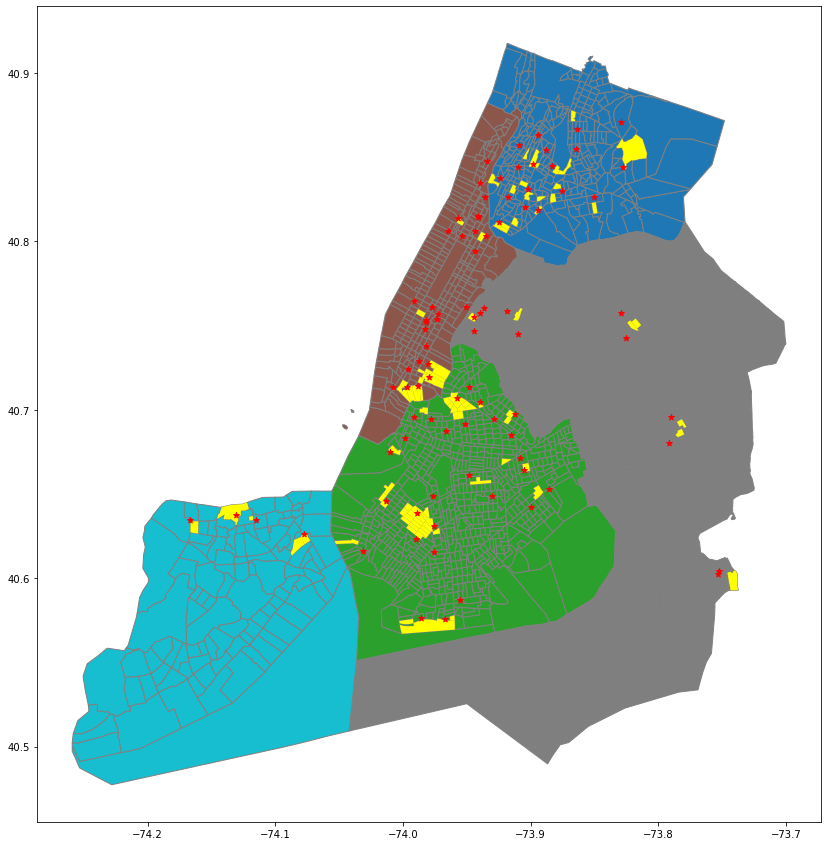

In [18]:
plt.figure(figsize=(15,15))
# The reset_index() here is just to let us use the county FIPS codes to color the counties distinctly.
nyc_joined.reset_index().plot('COUNTYFP', edgecolor='Grey', ax=plt.gca())
nyc_joined[low_broadband_tracts].plot(color='Yellow', ax=plt.gca())
libraries[low_broadband_libraries].plot(color='Red', marker='*', ax=plt.gca())

And we see that there are libraries relatively close to all the yellow areas.

But there's another problem -- the margins of error.

In [19]:
nyc_joined['PCT_HAVE_COMPUTER_AND_BROADBAND_MOE'].describe()

count    2096.000000
mean        6.798008
std         2.851110
min         0.000000
25%         5.394825
50%         6.731467
75%         8.040659
max        86.602540
Name: PCT_HAVE_COMPUTER_AND_BROADBAND_MOE, dtype: float64

What they mean is that if we ran the survey 90 times, we would expect the values to be inside $Estimate ± MoE$ 90% of the time.  These margins of error are mostly under 8%, but the largest is 85%! Since the ACS is only done once (well, 5 times, but don't ignore that) to generate these estimates, we can adjust our definition of low broadband penetration areas to **subtract the margin of error**, so we don't miss any areas due to sampling anomalies. (Let's leave the tract padding in, since it's nice to have.)

In [20]:
low_broadband_tracts = (nyc_joined['PCT_HAVE_COMPUTER_AND_BROADBAND'] -
                        nyc_joined['PCT_HAVE_COMPUTER_AND_BROADBAND_MOE']) < 60
sum(low_broadband_tracts)

252

In [21]:
low_broadband_libraries = libraries.intersects(nyc_joined[low_broadband_tracts].unary_union.buffer(0.01))
low_broadband_libraries.sum()

139

We've more than doubled the tracts that could be low broadband penetration, whereas the number of libraries has not risen at anywhere near the same rate. Is that OK? Let's plot it and see!

<AxesSubplot:>

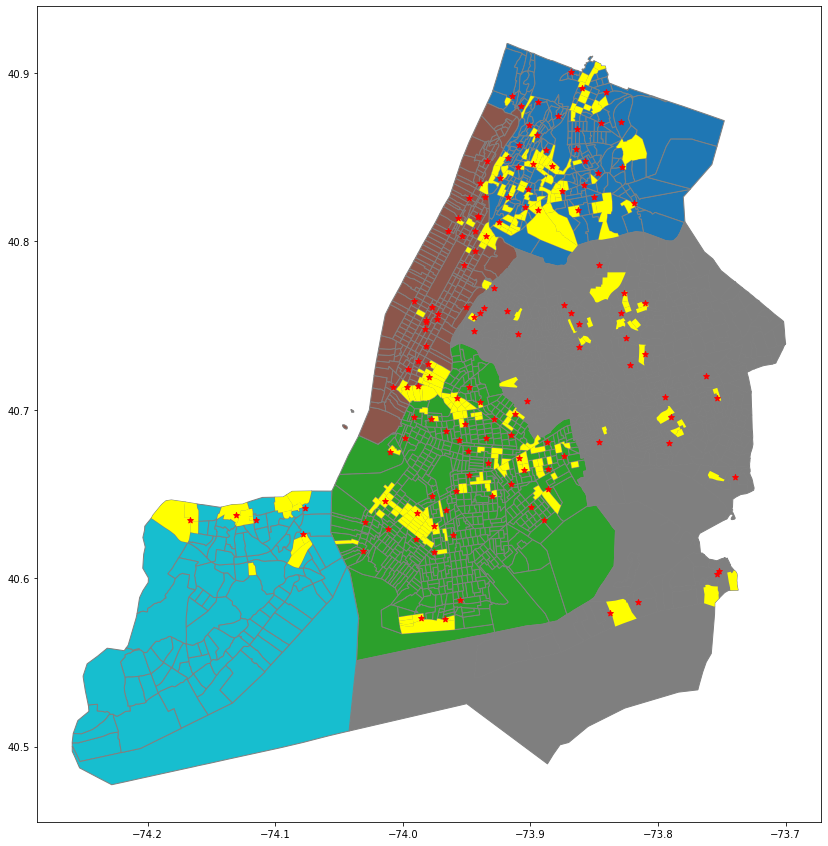

In [22]:
plt.figure(figsize=(15,15))
# The reset_index() here is just to let us use the county FIPS codes to color the counties distinctly.
nyc_joined.reset_index().plot('COUNTYFP', edgecolor='Grey', ax=plt.gca())
nyc_joined[low_broadband_tracts].plot(color='Yellow', ax=plt.gca())
libraries[low_broadband_libraries].plot(color='Red', marker='*', ax=plt.gca())

As one might (or might not) expect, a lot of the new areas are adjacent to the previously identified areas. So most of the libraries near the newly identified tracts were already included.

Which libraries are they?  Let's see:

In [23]:
pd.options.display.max_rows=None
libraries.loc[low_broadband_libraries, ['system', 'name', 'housenum', 'streetname', 'zip']].reset_index(drop=True)

,system,name,housenum,streetname,zip
0,NYPL,115th Street,203,West 115th Street,10026
1,NYPL,125th Street,224,East 125th Street,10035
2,NYPL,53rd Street,18,West 53rd Street,10019
3,NYPL,96th Street,112,East 96th Street,10128
4,NYPL,Aguilar,174,East 110th Street,10029
5,NYPL,Allerton,2740,Barnes Avenue,10467
6,NYPL,Baychester,2049,Asch Loop North,10475
7,NYPL,Belmont Library and Enrico Fermi Cultural Center,610,East 186th Street,10458
8,NYPL,Bronx Library Center,310,East Kingsbridge Road,10458
9,NYPL,Castle Hill,947,Castle Hill Avenue,10473


A few of these are closed or temporary locations that might not be there any more, but there's already more than can be easily covered for classes, so choosing subset of these, perhaps using the map to spread them out a bit, could be a good way to spread open data skills in these communities.